In [33]:
#Import Library
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [2]:
base_dir = 'image-model-1/'
os.listdir(base_dir)

['komedo', 'normal']

In [3]:
file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split("/")[-1])
        file_name.append(name)

In [4]:
df = pd.DataFrame({"path": full_path, "file_name": file_name, "tag": tag})
df.groupby(["tag"]).size()

tag
komedo    428
normal    480
dtype: int64

In [5]:
X = df["path"]
y = df["tag"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=5, stratify=y)

In [7]:
data_train = pd.DataFrame({"path": X_train, "tag": y_train, "set": "train"})
data_test = pd.DataFrame({"path": X_test, "tag": y_test, "set": "test"})

print("train size", len(data_train))
print("test size", len(data_test))

train size 726
test size 182


In [8]:
# Melihat proporsi training dan validation set
df_all = data_train.append([data_test]).reset_index(drop=1)
print(df_all.groupby(["set", "tag"]).size(), "\n")

# Cek sample data
df_all.sample(3)

set    tag   
test   komedo     86
       normal     96
train  komedo    342
       normal    384
dtype: int64 



C:\Users\User\AppData\Local\Temp\ipykernel_1500\3928688440.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = data_train.append([data_test]).reset_index(drop=1)


,path,tag,set
224,image-model-1/normal\n_0_972.jpg,normal,train
430,image-model-1/komedo\k_0_6405.jpg,komedo,train
592,image-model-1/normal\n_0_6153.jpg,normal,train


#### Data Preprocessing

Menggunakan `keras.preprocessing.image.ImageDataGenerator` class untuk membuat  train and validation dataset dan normalize data. 
Sangat penting untuk melakukan normalize data karena data akan diproses oleh CNN untuk improve performance secara keseluruhan. Disini kita akan menggunakan `rescale` parameter untuk scale our image pixel values dari [0, 255] ke [0,1].

Disetiap generator, kita menentukan source directory dari images, classes, input image size, batch size (seberapa banyak images yang akan diproses), dan class mode.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(
        data_train,
        x_col="path",
        y_col="tag",
        target_size=(200, 200),
        batch_size=72,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_dataframe(
        data_test,
        x_col="path",
        y_col="tag",
        target_size=(200, 200),
        batch_size=18,
        class_mode='binary',
        shuffle=False)

Found 726 validated image filenames belonging to 2 classes.
Found 182 validated image filenames belonging to 2 classes.



## Building the Model from Scratch

Memulai menentukan model:

Step 1 import tensorflow.

In [10]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

Menambahkan Conv2D layer akan mengoperasikan convolution pada layer tersebut, nilai stride dideskripsikan menggunakan 2 Dimensi meskipun dimensi stride tidak wajib sama misal 3,2 atau 4,5 dll. Pada layer convolution jumlah trainable parameter bukan menjadi jumlah neuron per layer  tapi hanya menunjukkan jumlah channel dan bobot per neuron. Parameter padding digunakan jika kita ingin jumlah neuron per channel sama dengan jumlah pixel citra, parameter 'same' menghasilkan padding yang diperlukan agar jumlah neuron=jumlah pixel. Jumlah neuron pada layer Conv2D tidak dideskripsikan karena sudah dideskripsikan oleh parameter lain, contoh: kombinasi padding='same' dan stride=(2,2) menghasilkan neuron separuh dari jumlah total pixel(ukuran gambar 200X200 3 channel->jumlah total pixel=120000, maka jumlah neuron akan menjadi 60000)
Menambahkan Flatten layer yang akan mem-flatten input image, dimana akan dilanjutkan ke next layer, Dense layer, atau fully-connected layer, dengan 128 hidden units, Flatten layer pada model ini tidak memerlukan input size karena sudah dideskripsikan pada Conv2D layer pertama
Pada tujuan akhirnya adalah untuk  melakukan binary classification, final layer akan menggunakan sigmoid, jadi output dari neural network akan menjadi single scalar antara 0 and 1, dengan melakukan encoding  probability pada image saat ini dengan class 
(class 1 menjadi rumput dan class 0 menjadi dandelion).

In [11]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            32,
            (5, 5),
            strides=(2, 2),
            activation="relu",
            padding="same",
            input_shape=(200, 200, 3),
            kernel_initializer="he_normal",
            bias_initializer="zeros",
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(
            64,
            (3, 3),
            strides=(2, 2),
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
            bias_initializer="zeros",
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(
            64,
            (3, 3),
            strides=(2, 2),
            activation="relu",
            padding="same",
            kernel_initializer="he_normal",
            bias_initializer="zeros",
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ]
)


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 2304)              0

Kolom "output shape"  menampilkan transformasi dari setiap dimensi layer sebagai hasil dari convolution and max pooling - convolution akan mengurangi layer size sedikit karena proses padding, dan max pooling membagi 2 output size.

Konfugirasi specifications untuk model training. Kita akan melakukan train model dengan `binary_crossentropy` loss. Kemudian menggunakan `Adam` optimizer. [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) adalah sensible optimization algorithm karena mengautomasi learning-rate tuning untuk kita (alternatifnya, kita bisa menggunakan [RMSProp](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) atau [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad) untuk hasil yang serupa). Kita akan menambahkan accuracy ke `metrics` jadi model akan memonitor accuracy saat melakukan training

In [13]:
model.compile(
    optimizer=tf.optimizers.Adam(), 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)


## Training

In [14]:
history = model.fit(train_generator,
      steps_per_epoch=8,  
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/10
8/8 [==============================] - 4s 472ms/step - loss: 0.7653 - accuracy: 0.5412 - val_loss: 0.7114 - val_accuracy: 0.5069
Epoch 2/10
8/8 [==============================] - 3s 357ms/step - loss: 0.5960 - accuracy: 0.6588 - val_loss: 0.5258 - val_accuracy: 0.7153
Epoch 3/10
8/8 [==============================] - 3s 371ms/step - loss: 0.4514 - accuracy: 0.7917 - val_loss: 0.6117 - val_accuracy: 0.6319
Epoch 4/10
8/8 [==============================] - 3s 366ms/step - loss: 0.4149 - accuracy: 0.7969 - val_loss: 0.3476 - val_accuracy: 0.8958
Epoch 5/10
8/8 [==============================] - 3s 343ms/step - loss: 0.3011 - accuracy: 0.8961 - val_loss: 0.2863 - val_accuracy: 0.8681
Epoch 6/10
8/8 [==============================] - 3s 343ms/step - loss: 0.2209 - accuracy: 0.9118 - val_loss: 0.1928 - val_accuracy: 0.9167
Epoch 7/10
8/8 [==============================] - 3s 338ms/step - loss: 0.1264 - accuracy: 0.9510 - val_loss: 0.3516 - val_accuracy: 0.8681
Epoch 8/10
8/8 [====

## Model Evaluate

Evaluasi accuracy model:

In [15]:
model.evaluate(validation_generator)

11/11 [==============================] - 1s 43ms/step - loss: 0.0908 - accuracy: 0.9780


[0.0907617062330246, 0.9780219793319702]

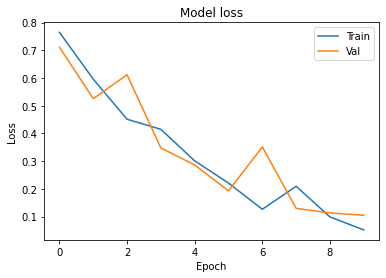

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

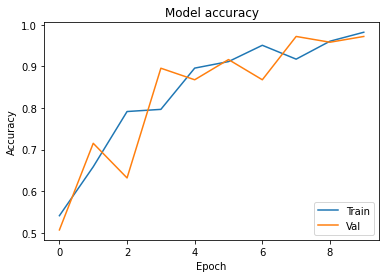

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

## Making Predictions

[1.]
[1.]
[1.]
[1.]
[1.1204224e-09]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]


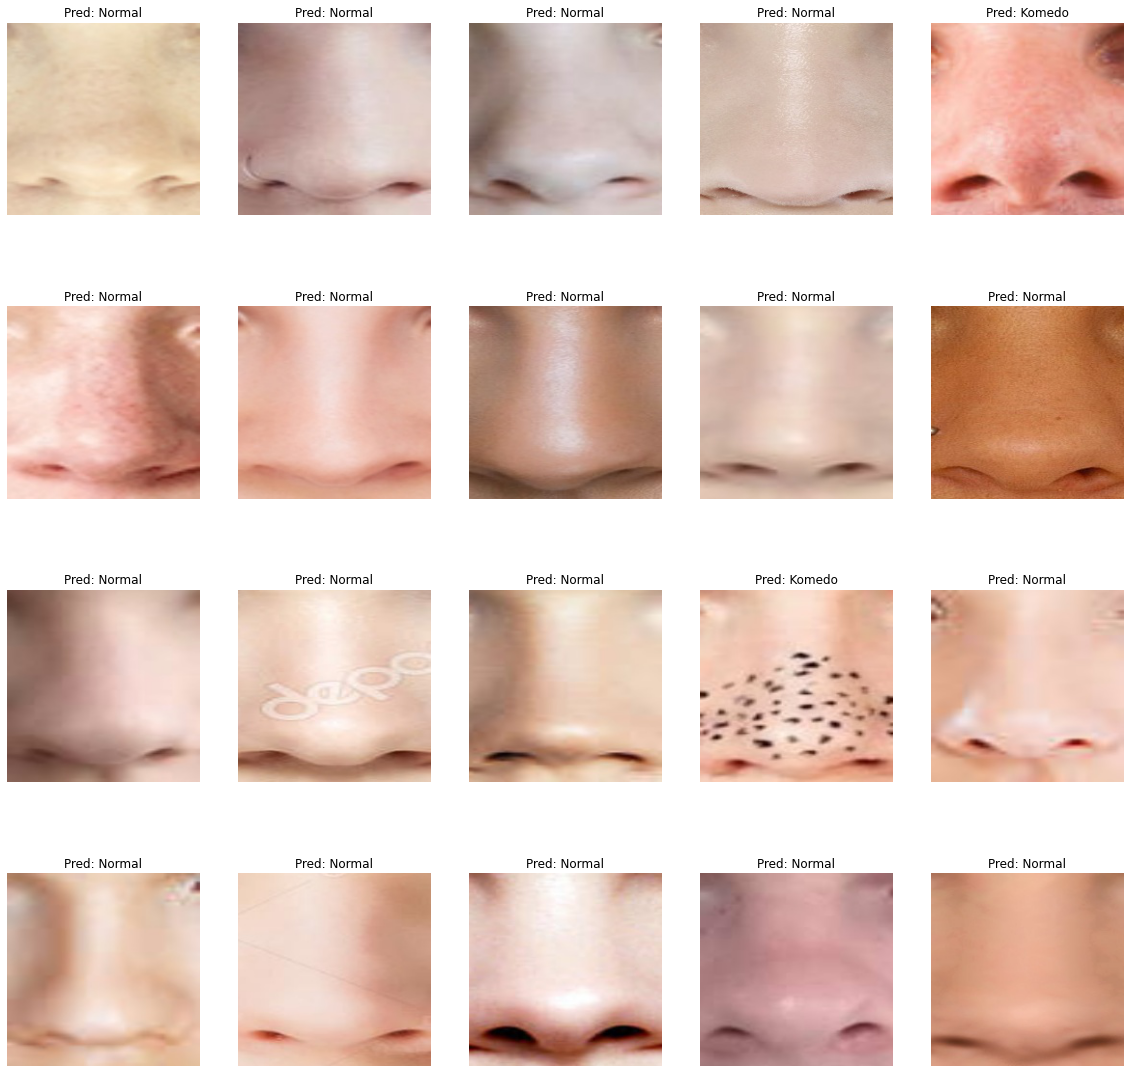

In [36]:
from keras.preprocessing import image

m = 1
columns = 5
rows = 4
directory = 'image-test-cropped/test-model-1'
pred_labels = ""
# iterate over files in
# that directory
fig = plt.figure(figsize=(20, 20))
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img = image.load_img(f, target_size=(200, 200))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model.predict(images, batch_size=10)
        print(classes[0])
        if classes[0]<0.5:
            pred_labels = 'Komedo'
        else:
            pred_labels = 'Normal'
            
        fig.add_subplot(rows, columns, m)
        plt.imshow(img)
        plt.axis('Off')
        plt.title("Pred: " + pred_labels)
        m += 1

In [42]:
y_pred = model.predict(validation_generator)
y_pred = np.round(y_pred)
y_pred

array([[1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],

In [43]:
y_test.replace(['komedo', 'normal'], [0, 1], inplace=True)
y_test

879    1
649    1
38     0
146    0
868    1
      ..
27     0
80     0
254    0
511    1
830    1
Name: tag, Length: 182, dtype: int64

In [44]:
categorical = ['komedo', 'normal']
classification_metrics = classification_report(y_pred, y_test, target_names=categorical)
print(classification_metrics)

              precision    recall  f1-score   support

      komedo       0.99      0.97      0.98        88
      normal       0.97      0.99      0.98        94

    accuracy                           0.98       182
   macro avg       0.98      0.98      0.98       182
weighted avg       0.98      0.98      0.98       182



<AxesSubplot:>

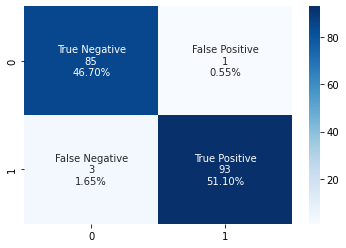

In [45]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ["True Negative", "False Positive", "False Negative", "True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")

In [26]:
# MODEL_BASE_PATH = "model"
# PROJECT_NAME = "ausion_project"
# SAVE_MODEL_NAME = "ausion.h5"
# save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
# if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
#     os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

# print("Saving Model At {}...".format(save_model_path))
# model.save(save_model_path, include_optimizer=False)